# Projeto Final

### Marcelo Lopes Valerio                       e-mail: mar.valerio@hotmail.com.br
## Projeto 10 - Treinamento de Redes Neurais com Transfer Learning

### Nesse projeto, foi pedido que, tendo como base um dataset com fotos de cachorros e gatos, separadas, fornecido pela documentação do TensorFlow, e o download foi feito pelo Kaggle, o dataset se chama cats and dogs.
### Como base para o desenvolvimento, foram utilizados:
- Um notebook, fornecido pelo orientador do desafio, que aplicava o conceito de Transfer Learning e redes neurais em um outro conjunto de imagens.
- A documentação do TensorFlow, disponível em: https://www.tensorflow.org
### Será utilizada a biblioteca de machine-learning citada acima, TensorFLow, para confecção de redes neurais. Mais especificamente, serão utilizadas as redes já montadas e disponibilizadas pela biblioteca, e será feita uma análise basica para definir qual, dentre 3 modelos, melhor se encaixa no projeto atual.
### O projeto foi construido no Google Collab, sendo assim, não foi necessária a instalação de nenhum pacote, somente a importação, realizada abaixo. Outra vantagem do Collab,é a possibilidade de utilizar a GPU disponibilizada pela empresa, melhorando o desempenho.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from time import time
import zipfile
from google.colab import drive
from sklearn.metrics import classification_report

## Formatando Imagens

### O formato do dataset foi adaptado para o projeto. O original possuia certa de 15000 fotos de cada classe, as quais foram reorganizadas da seguinte maneira: 
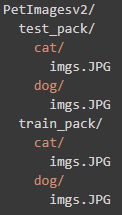

### O primeiro passo é extrair a pasta comprimida em um arquivo zip. O código abaixo fará isso, para um arquivo localizada no drive pessoal, dentro de uma pasta chamada DIO

In [3]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/DIO/PetImagesv2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

Mounted at /content/drive


### Após isso, é preciso formatar o conjunto de imagens, de maneira que a rede neural compreenda. Para isso, o próprio TensorFlow disponibiliza uma função, que processa as imagens e as salva em lotes de 32 objetos, chamados de tensores. Nessa função, para aumentar a eficiencia da rede neural, foram aplicados, aleatóriamente, zoom, rotação e alteração de brilho nas fotos.

In [4]:
# criando o dataset de treinamento
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True, zoom_range=0.1)
train_dataset = train_datagen.flow_from_directory('/content/PetImagesv2/train_pack',
                                                              target_size=(128, 128),
                                                              shuffle=False)

Found 2000 images belonging to 2 classes.


In [5]:
# criando o dataset de testagem
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_dataset = test_datagen.flow_from_directory('/content/PetImagesv2/test_pack',
                                                  target_size=(128, 128),
                                                  shuffle=False)

Found 2000 images belonging to 2 classes.


### Das fotos baixadas, algumas estavam corrompidas, então, ao rodar o codigo abaixo, é possível descobrir qual foto está corrompida:
```
! pip install pillow
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError
from PIL import Image

path = Path(r"C:\Users\marva\Desktop\PetImagesv2\train_pack\dog").rglob("*.jpg") # caminho da pasta com as fotos
for img_p in path:
    try:
        img = Image.open(img_p) # tenta abrir a imagem
    except PIL.UnidentifiedImageError:
            print(img_p) # se der erro, printa qual imagem eh
```

### Com isso, conclui-se que a imagem 666 de gatos estava corrompida, a qual foi substituida pela 2000. Caso, devido à compressão de arquivos, o código dê um erro na parte de 'network.fit', recomenda-se utilizar esse código no caminho do arquivo.
### Também foi disponibilizado o arquivo PetImagesv3, que contém 500 fotos de treino e 1500 de teste, para cada classe, e durante o notebook, serão apontadas as diferenças de desempenho notadas

## Escolhendo o modelo de rede neural
### Nessa etapa, testaremos 3 modelos de redes neurais pré-disponibilizados pelo TensorFLow: MobileNetV2, VGG16, e InceptionV3, utilizada pelo professor em aula. O parâmetro weights define os pesos, ou seja, os parâmetros dos calculos realizados pela rede, para maximizar a identificação de imagens. Uma abordagem mais profunda sobre layers será retomada mais a frente no projeto.

In [6]:
m1 = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))
out1 = m1.output
out1 = tf.keras.layers.GlobalAveragePooling2D()(out1)
out1 = tf.keras.layers.Dense(2, activation = 'softmax')(out1)

m2 = tf.keras.applications.VGG16(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))
out2 = m2.output
out2 = tf.keras.layers.GlobalAveragePooling2D()(out2)
out2 = tf.keras.layers.Dense(2, activation = 'softmax')(out2)

m3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))
out3 = m3.output
out3 = tf.keras.layers.GlobalAveragePooling2D()(out3)
out3 = tf.keras.layers.Dense(2, activation = 'softmax')(out3)

87910968/87910968 [==============================] - 1s 0us/step


In [7]:
# travando as camadas internas das redes, para que o treinamento já realizado nelas não seja perdido
nn_types = [m1, m2, m3]
for neuralnet in nn_types:
  for l, layer in enumerate(neuralnet.layers[:-1]):
    layer.trainable = False

In [8]:
# montagem das redes, utilizando o objeto Model do TF.
# mais dados dobre opmizer e loss podem ser lidos na documentação
network1 = tf.keras.models.Model(m1.inputs, out1)
network1.compile(loss = 'categorical_crossentropy', optimizer='Adam', 
                metrics = ['accuracy'])
network2 = tf.keras.models.Model(m2.inputs, out2)
network2.compile(loss = 'categorical_crossentropy', optimizer='Adam', 
                metrics = ['accuracy'])
network3 = tf.keras.models.Model(m3.inputs, out3)
network3.compile(loss = 'categorical_crossentropy', optimizer='Adam', 
                metrics = ['accuracy'])

In [9]:
# utilização do dataset de treino para treinar a rede MobileNetV2, e cronometragem
start = time()
training1 = network1.fit(train_dataset, epochs=3)
end = time()
t1 = end - start
print(f'Tempo: {t1}')

Epoch 1/3
63/63 [==============================] - 44s 630ms/step - loss: 0.4714 - accuracy: 0.7730
Epoch 2/3
63/63 [==============================] - 38s 595ms/step - loss: 0.1971 - accuracy: 0.9155
Epoch 3/3
63/63 [==============================] - 33s 510ms/step - loss: 0.1676 - accuracy: 0.9330
Tempo: 114.87102770805359


### Ao utilizar a versão com 500 fotos de teste, o resultado foi o seguinte:
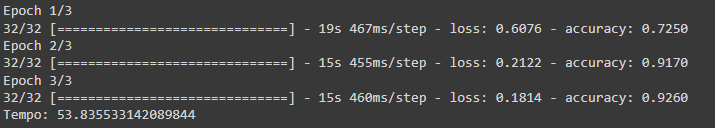

In [10]:
# utilização do dataset de treino para treinar a rede VGG16, e cronometragem
start = time()
training2 = network2.fit(train_dataset, epochs=3)
end = time()
t2 = end - start
print(f'Tempo: {t2}')

Epoch 1/3
63/63 [==============================] - 360s 6s/step - loss: 0.7815 - accuracy: 0.4545
Epoch 2/3
63/63 [==============================] - 377s 6s/step - loss: 0.6723 - accuracy: 0.5605
Epoch 3/3
63/63 [==============================] - 351s 6s/step - loss: 0.6348 - accuracy: 0.6455
Tempo: 1089.3521695137024


### Com o conjunto de 500 fotos:
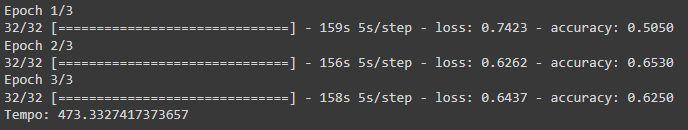

In [11]:
# utilização do dataset de treino para treinar a rede InceptionV3, e cronometragem
start = time()
training3 = network3.fit(train_dataset, epochs=3)
end = time()
t3 = end - start
print(f'Tempo: {t3}')

Epoch 1/3
63/63 [==============================] - 74s 1s/step - loss: 0.7043 - accuracy: 0.7705
Epoch 2/3
63/63 [==============================] - 72s 1s/step - loss: 0.3569 - accuracy: 0.8860
Epoch 3/3
63/63 [==============================] - 71s 1s/step - loss: 0.3546 - accuracy: 0.8850
Tempo: 240.75470519065857


### Com o conjunto de 500 fotos:
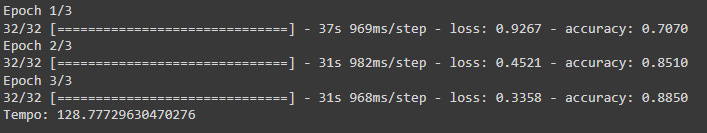

### A seguir, será aplicado um método que irá testar o desempenho na identificação de imagens no dataset teste para as 3 redes. Os parâmetros observados serão precisão e perda.

In [12]:
network1.evaluate(test_dataset)
network2.evaluate(test_dataset)
network3.evaluate(test_dataset)

63/63 [==============================] - 63s 974ms/step - loss: 0.3106 - accuracy: 0.8995


[0.3105524480342865, 0.8995000123977661]

### O conjunto de 500 fotos apresentou os seguintes resultados:
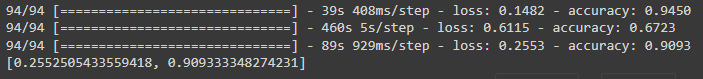

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currentl

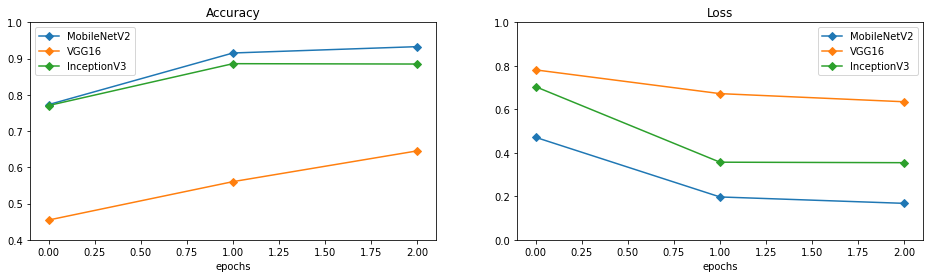

In [30]:
# plotando em um gráfico os dados obtidos acima
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(training1.history["accuracy"], label='MobileNetV2', marker='D')
ax.set_title("Accuracy")
ax.set_xlabel("epochs")
ax.set_ylim(0.4, 1)

ax2 = fig.add_subplot(121)
ax2.plot(training2.history["accuracy"], label='VGG16', marker='D')

ax3 = fig.add_subplot(121)
ax3.plot(training3.history["accuracy"], label='InceptionV3', marker='D')
plt.legend()

ax4 = fig.add_subplot(122)
ax4.plot(training1.history["loss"], label='MobileNetV2', marker='D')
ax4.set_title("Loss")
ax4.set_xlabel("epochs")
ax4.set_ylim(0, 1)

ax5 = fig.add_subplot(122)
ax5.plot(training2.history["loss"], label='VGG16', marker='D')

ax6 = fig.add_subplot(122)
ax6.plot(training3.history["loss"], label='InceptionV3', marker='D')
plt.legend()

plt.show()

### Gráficos do conjunto de 500 fotos de treino:
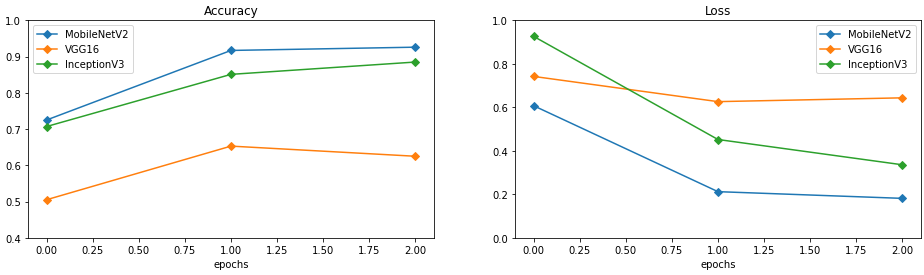

### Como é possível observar pelos gráficos, tempo de execução e avaliação da função evaluate, a rede do MobileNetV2 se mostrou superior, tanto em velocidade, quanto em precisão e em perda, logo, será a utilizada nos passos seguintes. Em relação à diferença entre um grupo de teste de 1000 ou de 500 fotos, foi possível observar que o tempo cai linearmente, enquanto o desempenho (precisão) caiu apenas 0,75% (95,25-94,5). Com isso, podemos concluir que, dependendo da aplicação, um treino com 500 fotos é suficiente.

## Aprimoramento da rede campeã
### Como foi observado, a rede com melhor desempenho foi a MobileNetV2, por apresentar a melhor precisão, e um tempo de processamento superior à VGG16 e InceptionV3, então, a seguir, será realizado o aprimoramento da mesma, para obter resultados ainda melhores

In [14]:
# Carregando o modelo base MobileNetV2.
mn2_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))

### Para uma melhor noção sobre a rede, chamaremos os seguintes métodos, para identificar quantas camadas tem no total, e uma descrição das ultimas camadas

In [15]:
mn2_base.summary()
print(len(mn2_base.layers))

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [16]:
# travando as camadas já treinadas
for l, layer in enumerate(mn2_base.layers[:-1]):
    layer.trainable = False

### Em seguida, adicionaremos mais camadas, na tentativa de melhorar o resultado obtido acima.
- A primeira, GlobalAveragePooling2D, é para conformar a saída da rede padrão do MobileNetV2, com as camadas que serão adicionadas posteriormente;
- As camadas chamadas Dense, adiciona uma camada de n neurônios. O atributo activations se refere ao tipo de camada, e não será abordado aqui;
- As camadas Dropout servem para descartar uma parte das conexões, para reduzir o fenômeno chamado overfitting;
- Note que a última camada tem apenas 2 neurônios, ela que irá definir se a imagem é gato (0), ou cachorro (1);
- Quanto mais camadas, mais tempo de processamento será necessário.

In [17]:
out = mn2_base.output
out = tf.keras.layers.GlobalAveragePooling2D()(out)
out = tf.keras.layers.Dense(640, activation = 'relu')(out)
out = tf.keras.layers.Dropout(0.25)(out)
out = tf.keras.layers.Dense(320, activation = 'relu')(out)
out = tf.keras.layers.Dropout(0.25)(out)
out = tf.keras.layers.Dense(160, activation = 'relu')(out)
out = tf.keras.layers.Dropout(0.25)(out)
out = tf.keras.layers.Dense(2, activation = 'softmax')(out)

In [18]:
# Montagem da rede nova
network = tf.keras.models.Model(mn2_base.input, out)

In [19]:
# Verificando se as camadas foram adicionadas
len(network.layers)

162

### O método compile prepara a rede para o treinamento, definindo o meio de minimização da perda (entropia cruzada categórica), o otimizador, que é uma classse biult-in da biblioteca, e as métricas utilizadas para quantificar a eficiencia do treino (precisão)

In [20]:
network.compile(loss = 'categorical_crossentropy', optimizer='Adam', 
                metrics = ['accuracy'])

### Realização do treinamento, com o método fit, e o dataset de treino. Como no teste preliminar, com apenas 3 epochs (entenda iterações, ou vezes treinando) ja pareceu indicar algum tipo de patamar, serão realizados apenas 5 epochs.

In [21]:
training = network.fit(train_dataset, epochs=5)

Epoch 1/5
63/63 [==============================] - 38s 544ms/step - loss: 0.8787 - accuracy: 0.7865
Epoch 2/5
63/63 [==============================] - 33s 515ms/step - loss: 0.1684 - accuracy: 0.9355
Epoch 3/5
63/63 [==============================] - 33s 516ms/step - loss: 0.1388 - accuracy: 0.9470
Epoch 4/5
63/63 [==============================] - 33s 514ms/step - loss: 0.1343 - accuracy: 0.9530
Epoch 5/5
63/63 [==============================] - 34s 542ms/step - loss: 0.1068 - accuracy: 0.9565


### O conjunto de treino com 500 fotos apresentou os seguintes resultados:
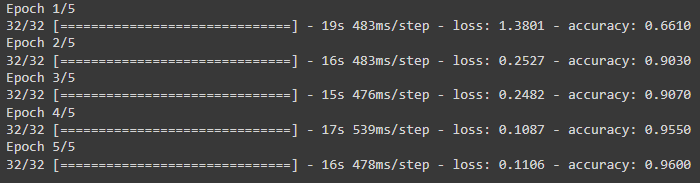

In [22]:
# Avaliando o desempenho da rede neural MobileNetV2 melhorada
network.evaluate(test_dataset)

63/63 [==============================] - 27s 412ms/step - loss: 0.0817 - accuracy: 0.9680


[0.08165761083364487, 0.9679999947547913]

### Avaliação do conjunto de treino de 500 fotos, e 1500 de teste:
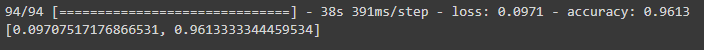

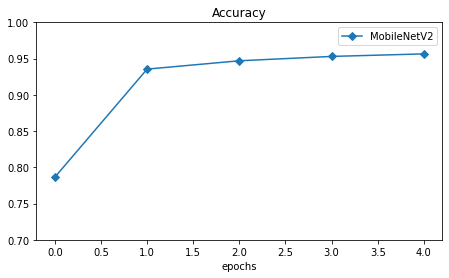

In [31]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(training.history["accuracy"], label = 'MobileNetV2', marker='D')
ax.set_title("Accuracy")
ax.set_xlabel("epochs")
ax.set_ylim(0.7, 1)
plt.legend()
plt.show()

### Enquanto isso, o gráfico do grupo de 500 fotos ficou o seguinte:
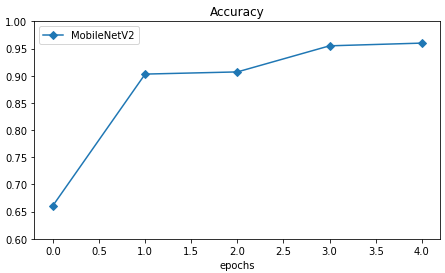

### É possível notar que, embora o começo não foi tão semelhante, devido ao numero maior de épocas, o modelo de 500 fotos conseguiu se recuperar, e, novamente, com metade do tempo de treino, apresentou uma variação de apenas 0,67%, mantendo o comportamento esperado

### Além disso, com todas as alterações realizadas, uma diferença imperceptível no tempo de processamento por geração, a precisão aumentou em 1,5%. Embora, em termos absolutos essa alteração na precisão não seja tão significativa, considerando que o tempo de processamento não aumentou, e para os objetivos desse estudo, de compreensão do processo de criação, aprimoramento e utilização de uma rede neural, o resultado foi bom.

### Agora serão realizadas previsões no dataset test, para analizar como é a saída da função

In [24]:
# previsões sobre o dataset teste
probs = network.predict(test_dataset)
# A predição retorna uma lista com 2 val [x,y], com a chance de ser gato(x), ou cachorro(y), então,
#para pegar o que a rede neural achou mais provável, utiliza-se a função abaixo abaixo
guess = np.argmax(probs, axis = 1)
print(guess)

63/63 [==============================] - 28s 424ms/step
[0 0 0 ... 1 1 1]


### Todos os campos onde guess apresentar valor 0, significa que a rede neural identificou um gato, enquanto que, quando for 1, indica um cachorro

In [25]:
# Comparar o match do conjunto teste segundo as previsões, e o real
preview_list = guess.tolist()
real_list = test_dataset.classes.tolist()
count = 0
for index, preview in enumerate(preview_list):
  if preview == real_list[index]:
    count += 1
print(count/len(preview_list))
# Note que o valor é o mesmo que o resultado de accuracy, no network.evaluate, acredito que ele realize o mesmo procedimento

0.968


### Agora, será chamado o classificaton_report, que toma como parâmetros os valores reais, e os previstos, e retorna uma análise estatística do conjunto

In [26]:
classification_report(test_dataset.classes, guess)

'              precision    recall  f1-score   support\n\n           0       0.96      0.98      0.97      1000\n           1       0.98      0.96      0.97      1000\n\n    accuracy                           0.97      2000\n   macro avg       0.97      0.97      0.97      2000\nweighted avg       0.97      0.97      0.97      2000\n'

### Por último, a rede neural será chamada para julgar uma única foto, apenas por curiosidade, e para testar se é possível chamá-la a qualquer momento

1/1 [==============================] - 1s 887ms/step
Eh um gato


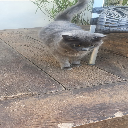

1/1 [==============================] - 0s 42ms/step
Eh um cachorro


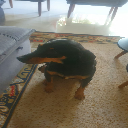

1/1 [==============================] - 0s 43ms/step
Eh um gato


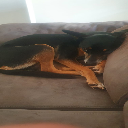

In [27]:
import cv2
from google.colab.patches import cv2_imshow
paths = ['/content/PetImagesv2/meus_bixo/Nina.jpeg', 
         '/content/PetImagesv2/meus_bixo/Cisco.jpeg', 
         '/content/PetImagesv2/meus_bixo/Pipoca.jpeg']
for path in paths:
  pic = cv2.imread(path) # pegando a imagem do meu pet
  pic = cv2.resize(pic, (128, 128))
  tensor = pic/255
  tensor = tensor.reshape(1,128,128,3)
  preview = network.predict(tensor)
  preview = np.argmax(preview)
  print('Eh um cachorro' if preview == 1 else 'Eh um gato')
  cv2_imshow(pic)

### Podemos ver que, embora tenha um bom desempenho, nada está livre de erros, às vezes por uma foto mal tirada, ou pouca resolução, a rede pode acabar se confundindo